In [1]:
import sys
print (sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]


In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from skimage import io
import numpy as np
import superpixels as sp
import glob
import pipeline as pipe
import time
import superpixels as sp
import scipy.stats as sci
from PIL import Image
from scipy import ndimage
import cv2

In [4]:
import argparse
import LoadBatches
from Models import Segnet, Unet, VGGSegnet, VGGUnet, FCN8, FCN32
from keras.optimizers import SGD
import random

Using TensorFlow backend.


### Parameters

In [25]:
#train path and batch size
train_images_path = '/media/falreis/falreis2/mestrado/deep_learning/BSDS500/pre_process/X/images/train/'
train_segs_path = '/media/falreis/falreis2/mestrado/deep_learning/BSDS500/pre_process/X/colorTruth/train/'
train_batch_size = 2 #args.batch_size

#val path and batch size
val_images_path = '/media/falreis/falreis2/mestrado/deep_learning/BSDS500/pre_process/X/images/val/'
val_segs_path = '/media/falreis/falreis2/mestrado/deep_learning/BSDS500/pre_process/X/colorTruth/val/'
val_batch_size = 2 #args.val_batch_size

#weights
save_weights_path = '/media/falreis/falreis2/mestrado/deep_learning/weights/'
load_weights = '' #'.model.4' #args.load_weights

#input height and width
input_height = 360 #481 #args.input_height
input_width = 480 #481 #args.input_width

#classes, validade and epochs
n_classes = 2 #args.n_classes
validate = 'store_false' #args.validate
epochs = 2 #args.epochs

#optmizer and model name
#optimizer_name = 'adam' #args.optimizer_name
optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model_name = 'segnet' #args.model_name

## Train

In [47]:
modelFns = { 'segnet':Segnet.Segnet
            , 'unet':Unet.Unet
            , 'vgg_segnet':VGGSegnet.VGGSegnet
            , 'vgg_unet':VGGUnet.VGGUnet
            , 'vgg_unet2':VGGUnet.VGGUnet2
            , 'fcn8':FCN8.FCN8
            , 'fcn32':FCN32.FCN32   
}
modelFN = modelFns[ model_name ]

m = modelFN(n_classes , input_height=input_height, input_width=input_width)
m.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

if len( load_weights ) > 0:
    m.load_weights(save_weights_path + load_weights)

print("Model output shape" ,  m.output_shape)

output_height = m.outputHeight
output_width = m.outputWidth

validate = False

Model output shape (None, 172800, 2)


In [55]:
G  = LoadBatches.imageSegmentationGenerator(train_images_path
                                            , train_segs_path
                                            , train_batch_size
                                            , n_classes
                                            , input_height
                                            , input_width
                                            , output_height
                                            , output_width
)

if validate:
    G2  = LoadBatches.imageSegmentationGenerator(val_images_path
                                                 , val_segs_path
                                                 , val_batch_size
                                                 , n_classes
                                                 , input_height
                                                 , input_width
                                                 , output_height
                                                 , output_width
)

if not validate:
    for ep in range(epochs):
        m.fit_generator(G, 32, nb_epoch=1)
        m.save_weights(save_weights_path + "." + str(ep))
        m.save(save_weights_path + ".model." + str(ep))
else:
    for ep in range(epochs):
        m.fit_generator(G, 32, validation_data=G2, validation_steps=10, nb_epoch=1)
        m.save_weights(save_weights_path + "." + str(ep))
        m.save(save_weights_path + ".model." + str(ep))

TypeError: 'generator' object is not subscriptable

## Predict

In [15]:
#input and output images
images_path='/media/falreis/falreis2/mestrado/deep_learning/BSDS500/pre_process/X/images/val/'
output_path='/media/falreis/falreis2/mestrado/deep_learning/BSDS500/predict/'

epoch_number = 2 #epochs - 1

(88, 8, 2)


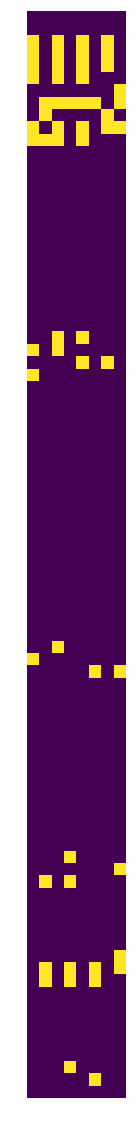

In [16]:
images = glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") 
images.sort()

for imgName in images:
    outName = imgName.replace(images_path, output_path)
    X = LoadBatches.getImageArr(imgName, input_width, input_height)
    output = m.predict_proba(np.array([X]))
    output = output.reshape((output.shape[0], output_height, output_width, n_classes))
    
    print(output[0].shape)
    
    fig, (ax1) = plt.subplots(1,1, figsize=(20, 20))
    ax1.imshow(np.argmax(output[0], axis=-1))
    ax1.set_axis_off()
    plt.show()

In [ ]:
images = glob.glob( images_path + "*.jpg"  ) + glob.glob( images_path + "*.png"  ) +  glob.glob( images_path + "*.jpeg"  )
images.sort()

colors = [  ( random.randint(0,255),random.randint(0,255),random.randint(0,255)   ) for _ in range(n_classes)  ]

for imgName in images:
    outName = imgName.replace(images_path, output_path )
    X = LoadBatches.getImageArr(imgName, input_width, input_height)
    pr = m.predict(np.array([X]))[0]
    
    
    
    pr = pr.reshape(( output_height ,  output_width , n_classes ) ).argmax( axis=2 )
    seg_img = np.zeros( ( output_height , output_width , 3  ) )
    
    for c in range(n_classes):
        seg_img[:,:,0] += ( (pr[:,: ] == c )*( colors[c][0] )).astype('uint8')
        seg_img[:,:,1] += ((pr[:,: ] == c )*( colors[c][1] )).astype('uint8')
        seg_img[:,:,2] += ((pr[:,: ] == c )*( colors[c][2] )).astype('uint8')
    seg_img = cv2.resize(seg_img  , (input_width , input_height ))
      
    cv2.imwrite(  outName , seg_img )
    
print('Done')

## Draw Module

In [ ]:
from keras import utils
utils.plot_model(m, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')
#keras.utils.to_categorical(y, num_classes=None)
#plot(m, to_file='model.png', show_shapes=True)